# Unsupervised Learning

# 04_create_unsupervised_features

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 28/09/2025   | Adrienne | Created | Created file for unsupervised learning | 
| 29/09/2025   | Martin | New   | Processing to apply the HCPCS code descriptions + EDA on the new descriptions | 
| 02/10/2025 | Adrienne | Update | Created features |
| 05/10/2025 | Martin | Update | Added TFIDF transformation section for any "list-like" columns |
| 05/10/2025 | Adrienne | Update | Added a feature and cleaned up dataset to include relevant columns

## Notes

- Preventative care indicator

## Content

* [Introduction](#introduction)
* [Load Data](##load-data)
* [Additional Features](#additional-features)
* [EDA](#eda)

## Introduction

In [3]:
%load_ext watermark

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

## Load Data

In [223]:
path = "../data/clean"
df = pd.read_pickle(f"{path}/patient_level.pkl")
#df = pd.read_pickle(f"{path}/patient_level_sample.pkl")

In [224]:

mapper_path = "../data/mappers"
combined_mapper = pd.read_pickle(f"{mapper_path}/combined_mapper.pkl")

In [225]:
combined_mapper.head()

,code,category,description
0,99201,HCPCS_level_1,Evaluation and Management (E/M) Codes
1,99202,HCPCS_level_1,Evaluation and Management (E/M) Codes
2,99203,HCPCS_level_1,Evaluation and Management (E/M) Codes
3,99204,HCPCS_level_1,Evaluation and Management (E/M) Codes
4,99205,HCPCS_level_1,Evaluation and Management (E/M) Codes


Need to drop columns that would be a source of data leakage or are not needed

In [226]:
# diagnosis columns:
keep_cols = ['patient_medicare_number', 'gender', 'age', 'number_of_claims', 'combined_hcpcs_ls', 'billablePeriod_start_ls', 'billablePeriod_end_ls', 'location_of_bill_ls', 'total_value']
df = df[keep_cols]

Just drop rows where age is missing

In [227]:
df[df['age'].isnull()]

,patient_medicare_number,gender,age,number_of_claims,combined_hcpcs_ls,billablePeriod_start_ls,billablePeriod_end_ls,location_of_bill_ls,total_value
8592,1S00E00GA64,male,NaN,49,"[99241, 99241, 99241, 99241, 99241, 99241, 992...","[2012-04-24, 2012-05-22, 2012-12-04, 2013-05-1...","[2012-04-24, 2012-05-22, 2012-12-04, 2013-05-1...",[],101.17
14425,1S00E00GK24,male,NaN,18,"[99241, 99241, 99241, 99241, 99241, 99241, 992...","[2013-10-14, 2013-12-16, 2015-07-13, 2016-01-0...","[2013-10-14, 2013-12-16, 2015-07-13, 2016-01-0...",[],114.90
36187,1S00E00HT00,male,NaN,99,"[99241, 99241, 99241, 99241, 99241, 99241, 992...","[2012-02-19, 2012-04-15, 2012-05-13, 2012-06-1...","[2012-02-19, 2012-04-15, 2012-05-13, 2012-06-1...",[],142.58
53496,1S00E00JU46,male,NaN,40,"[99241, 99241, 99241, 99241, 99241, 99241, 992...","[2013-10-25, 2015-03-20, 2015-12-11, 2016-02-1...","[2013-10-25, 2015-03-20, 2015-12-11, 2016-02-1...",[],123.66
72387,1S00E00ME11,male,NaN,91,"[99241, 99241, 99241, 99241, 99241, 99241, 992...","[2012-05-14, 2012-06-11, 2012-07-23, 2012-09-1...","[2012-05-14, 2012-06-11, 2012-07-23, 2012-09-1...",[],105.46
75119,1S00E00MH19,male,NaN,44,"[99241, 99241, 99241, 99241, 99241, 99241, 992...","[2012-04-30, 2012-05-21, 2012-06-18, 2013-05-2...","[2012-04-30, 2012-05-21, 2012-06-18, 2013-05-2...",[],134.38


In [228]:
df = df[df['age'].notnull()]

Limiting patients to those with less than 1000 in the combined_hcpcs_ls as it's just five patients and it drops the longest length to 670

In [229]:
df['ls_len'] = df['combined_hcpcs_ls'].str.len()
df = df[df['ls_len'] < 1000]

## Additional Features

Focusing on transforming the HCPCS codes into a useable format for unsupervised learning.

- HCPCS
  - code
  - category
  - description

## Apply mapper to HCPCS lists

Using the mapper we can apply the additional columns with category and description to each column of HCPCS

In [230]:
# drop hcpcs columns that are all NaN
print(len(df))
df.dropna(axis=1, how='all', inplace=True)
print(len(df))

2282
2282


In [231]:
unique_values = set(value for sublist in df['combined_hcpcs_ls'] for value in sublist)
print(unique_values)
print(len(unique_values))

{'G0464', 'G9829', 'S9129', 'G0444', 'G9857', 'S9122', 'T1021', 'G0107', 'G0156', 'G8159', 'G0154', '99241', 'G0402', 'S8075', 'S9131', 'H2000', 'S0605', 'G0299', 'T1502', 'G0157', 'G0153', 'G8111', 'G0300', 'G9833', 'G9572', 'C8928', 'G0158', 'S9126', 'G0155', 'G0458', 'G0129', 'G0102', 'S9473', 'G8946', 'G0424', 'G9858', 'G0151', 'G9708', 'G0152', 'C8905', 'Q5001', 'G9573', '99221', 'C8908'}
44


In [232]:
maxlen = max(df['combined_hcpcs_ls'].str.len())
print(f"max combined_hcpcs_ls length: {maxlen}")
df_hcpcs = df['combined_hcpcs_ls'].apply(pd.Series)
df_hcpcs = df_hcpcs.add_prefix('hcpcs_')
df_hcpcs = pd.concat([df, df_hcpcs], axis = 1)
df_hcpcs.head()

max combined_hcpcs_ls length: 670


,patient_medicare_number,gender,age,number_of_claims,combined_hcpcs_ls,billablePeriod_start_ls,billablePeriod_end_ls,location_of_bill_ls,total_value,ls_len,...,hcpcs_660,hcpcs_661,hcpcs_662,hcpcs_663,hcpcs_664,hcpcs_665,hcpcs_666,hcpcs_667,hcpcs_668,hcpcs_669
1,1S00E00AA10,female,79.0,18,"[G0444, 99221, G0444, G0444, G0444, 99221, 992...","[2012-04-17, 2012-05-15, 2013-04-23, 2014-04-2...","[2012-04-17, 2012-05-15, 2013-04-23, 2014-04-2...","[002, 002, 002, 002, 002, 002, 002, 002, 002, ...",149.37,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,1S00E00AA16,male,75.0,17,"[99241, G0444, 99241, G0444, 99241, G0444, G95...","[2012-09-23, 2012-10-20, 2013-09-23, 2013-10-2...","[2012-09-23, 2012-10-20, 2013-09-23, 2013-10-2...","[002, 002, 002, 002, 002, 002, 002, 002, 002, ...",234.72,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,1S00E00AA23,female,77.0,29,"[99241, 99241, 99241, G0444, 99241, 99241, 992...","[2012-01-21, 2012-02-22, 2012-03-01, 2012-04-0...","[2012-01-21, 2012-02-22, 2012-03-01, 2012-04-0...","[002, 002, 002, 002, 002, 002, 002, 002, 002, ...",85.55,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,1S00E00AA25,female,78.0,24,"[G0107, G0444, 99241, G0444, G0444, 99241, G04...","[2012-04-15, 2012-07-18, 2013-07-13, 2013-07-2...","[2012-04-15, 2012-07-18, 2013-07-13, 2013-07-2...","[002, 002, 002, 002, 002, 002, 002, 002, 002, ...",21901.40,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,1S00E00AA32,male,80.0,19,"[G0444, 99241, G0444, G0444, G0444, G9572, 992...","[2012-05-05, 2013-03-21, 2013-03-30, 2013-05-1...","[2012-05-05, 2013-03-21, 2013-03-30, 2013-05-1...","[002, 002, 002, 002, 002, 002, 002, 002, 002]",8388.69,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [233]:
for i in range(maxlen):
  df_hcpcs = pd.merge( df_hcpcs, 
    combined_mapper,
    left_on=f"hcpcs_{i}",
    right_on="code",
    how='left'
  )
  df_hcpcs = df_hcpcs.drop(['code'], axis=1)
  df_hcpcs = df_hcpcs.rename({
    'category': f"category_{i}",
    'description': f"description_{i}",
  }, axis=1)

df_hcpcs_combined = df_hcpcs.fillna(np.nan)

In [234]:
df_hcpcs_combined[['hcpcs_1', 'category_1', 'description_1', 'hcpcs_2', 'category_2',  'description_2']].head()

,hcpcs_1,category_1,description_1,hcpcs_2,category_2,description_2
0,99221,HCPCS_level_1,Evaluation and Management (E/M) Codes,G0444,HCPCS_level_2,Procedures/Professional Services
1,G0444,HCPCS_level_2,Procedures/Professional Services,99241,HCPCS_level_1,Evaluation and Management (E/M) Codes
2,99241,HCPCS_level_1,Evaluation and Management (E/M) Codes,99241,HCPCS_level_1,Evaluation and Management (E/M) Codes
3,G0444,HCPCS_level_2,Procedures/Professional Services,99241,HCPCS_level_1,Evaluation and Management (E/M) Codes
4,99241,HCPCS_level_1,Evaluation and Management (E/M) Codes,G0444,HCPCS_level_2,Procedures/Professional Services


## Time interval between claims

Using `billablePeriod_end_ls`, sort and compare the time interval of days between each claim. Then expand it out into individual columns

In [235]:
def days_between_claim(item):
  sorted_dates = pd.to_datetime(pd.Series(item)).sort_values().reset_index(drop=True)
  return sorted_dates.diff().dt.days.dropna().astype(int).tolist()

In [236]:
day_interval = pd.DataFrame(df['billablePeriod_end_ls'].apply(days_between_claim))
day_maxlen = max(day_interval['billablePeriod_end_ls'].str.len())
df_day_interval = pd.DataFrame(day_interval['billablePeriod_end_ls'].to_list(), columns=[f"day_interval_{i}" for i in range(day_maxlen)])
df_day_interval.head()

,day_interval_0,day_interval_1,day_interval_2,day_interval_3,day_interval_4,day_interval_5,day_interval_6,day_interval_7,day_interval_8,day_interval_9,...,day_interval_655,day_interval_656,day_interval_657,day_interval_658,day_interval_659,day_interval_660,day_interval_661,day_interval_662,day_interval_663,day_interval_664
0,28,343,371,371,14,241,3,106,52,92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,27,338,33,332,39,326,45,137,183,365,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,32,8,31,44,9,3,18,28,84,140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,94,360,11,371,124,247,136,235,74,61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,320,9,42,371,360,11,371,289,82,29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Variable Encoding

Will make three datasets with three different versions of the features:
- df_lab_enc: will have the hcpcs columns encoded using label encoding
- df_freq_enc: will have the hcpcs columns encoded using frequency encoding
- df_TD_enc: will use the combined_hcpcs_ls column and treat it like a bag of words problem and use a TD-IDF transformation

There are some variables that will always be label encoded

In [237]:
# will always encode gender using labels
le_gen = LabelEncoder()
df_hcpcs_combined['gender'] = le_gen.fit_transform(df_hcpcs_combined['gender'])

In [238]:
# create a list of cateogory columns
category_cols = df_hcpcs_combined.columns[df_hcpcs_combined.columns.str.contains("category")]

# create a dataframe of unique category values for encoding
ls = list(set(value for value in combined_mapper['category']))
# new columns are filled with nan
ls.append(np.nan)
df_unique_category = pd.DataFrame( {'unique_category': ls})


# create instance of label encoder
le = LabelEncoder()
# fit label encoding on first category column
le.fit(df_unique_category['unique_category'])
 
# apply same encoder to rest of columns
for col in category_cols:
    df_hcpcs_combined[col + '_enc'] = le.transform(df_hcpcs_combined[col])

/var/folders/h7/vnb5cqf52l31_n7r6zv3j6z80000gn/T/ipykernel_14325/543955457.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_hcpcs_combined[col + '_enc'] = le.transform(df_hcpcs_combined[col])
/var/folders/h7/vnb5cqf52l31_n7r6zv3j6z80000gn/T/ipykernel_14325/543955457.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_hcpcs_combined[col + '_enc'] = le.transform(df_hcpcs_combined[col])
/var/folders/h7/vnb5cqf52l31_n7r6zv3j6z80000gn/T/ipykernel_14325/543955457.py:18: PerformanceWarning: DataFrame is highly fragmented.  T

In [215]:
# create a list of description columns
desc_cols = df_hcpcs_combined.columns[df_hcpcs_combined.columns.str.contains("description")]

# create a dataframe of unique description values for encoding
ls = list(set(value for value in combined_mapper['description']))
# new columns are filled with nan
ls.append(np.nan)
df_unique_desc = pd.DataFrame( {'unique_desc': ls})


# create instance of label encoder
le = LabelEncoder()
# fit label encoding on first description column
le.fit(df_unique_desc['unique_desc'])
 
# apply same encoder to rest of columns
for col in desc_cols:
    df_hcpcs_combined[col + '_enc'] = le.transform(df_hcpcs_combined[col])

/var/folders/h7/vnb5cqf52l31_n7r6zv3j6z80000gn/T/ipykernel_14325/1455330512.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_hcpcs_combined[col + '_enc'] = le.transform(df_hcpcs_combined[col])
/var/folders/h7/vnb5cqf52l31_n7r6zv3j6z80000gn/T/ipykernel_14325/1455330512.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_hcpcs_combined[col + '_enc'] = le.transform(df_hcpcs_combined[col])
/var/folders/h7/vnb5cqf52l31_n7r6zv3j6z80000gn/T/ipykernel_14325/1455330512.py:18: PerformanceWarning: DataFrame is highly fragmented.

In [239]:
# create a list of hcpcs columns
# first col in list needs to be dropped
hcpcs_cols = df_hcpcs_combined.columns[df_hcpcs_combined.columns.str.contains("hcpcs")][1:]

# create a dataframe of unique hcpcs values for encoding
ls = list(set(value for sublist in df_hcpcs_combined['combined_hcpcs_ls'] for value in sublist))
# new hcpcs columns are filled with nan
ls.append(np.nan)
df_unique_hcpcs = pd.DataFrame( {'unique_hcpcs': ls})


In [240]:
# create copies of the dataset
df_lab_enc = df_hcpcs_combined.copy()
df_freq_enc = df_hcpcs_combined.copy()
df_TD_enc = df_hcpcs_combined.copy()

### Label Encoding HCPCS

In [ ]:
# create instance of label encoder
le = LabelEncoder()
# fit label encoding on first hcpcs column
le.fit(df_unique_hcpcs['unique_hcpcs'])
 
# apply same encoder to rest of columns
for col in hcpcs_cols:
    df_lab_enc[col + '_enc'] = le.transform(df_lab_enc[col])

/var/folders/h7/vnb5cqf52l31_n7r6zv3j6z80000gn/T/ipykernel_14325/3169663431.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lab_enc[col + '_enc'] = le.transform(df_lab_enc[col])
/var/folders/h7/vnb5cqf52l31_n7r6zv3j6z80000gn/T/ipykernel_14325/3169663431.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lab_enc[col + '_enc'] = le.transform(df_lab_enc[col])
/var/folders/h7/vnb5cqf52l31_n7r6zv3j6z80000gn/T/ipykernel_14325/3169663431.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

In [242]:
# check encodings
df_lab_enc[['category_0', 'category_0_enc', 'hcpcs_0', 'hcpcs_0_enc', 'hcpcs_1', 'hcpcs_1_enc', 'hcpcs_2', 'hcpcs_2_enc', 'gender']].head()

,category_0,category_0_enc,hcpcs_0,hcpcs_0_enc,hcpcs_1,hcpcs_1_enc,hcpcs_2,hcpcs_2_enc,gender
0,HCPCS_level_2,2,G0444,20,99221,0,G0444,20,0
1,HCPCS_level_1,1,99241,1,G0444,20,99241,1,1
2,HCPCS_level_1,1,99241,1,99241,1,99241,1,0
3,HCPCS_level_2,2,G0107,6,G0444,20,99241,1,0
4,HCPCS_level_2,2,G0444,20,99241,1,G0444,20,1


In [243]:
# drop original columns and list columns
drop_ls = list(category_cols) + list(desc_cols) + list(hcpcs_cols) + ['patient_medicare_number', 'combined_hcpcs_ls', 'billablePeriod_start_ls', 'billablePeriod_end_ls','location_of_bill_ls', 'ls_len']
df_lab_enc = df_lab_enc.drop(drop_ls, axis = 1)

In [244]:
df_lab_enc.to_pickle("../data/clean/patient_level_lab_enc.pkl")

### Frequency Encoded HCPCS

In [ ]:



freq_enc = df_hcpcs_combined.groupby('combined_hcpcs_ls')
 
# apply same encoder to rest of columns
for col in hcpcs_cols:
    df_lab_enc[col + '_enc'] = le.transform(df_lab_enc[col])

### TD_IDF Encoding

In [23]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline

In [24]:
df_hcpcs_reset = df_hcpcs.reset_index(drop=True)
list_cols = df_hcpcs_reset.columns[:12]
df_hcpcs_reset[list_cols].head()

,patient_medicare_number,patient_first_name,patient_last_name,gender,birthdate,number_of_claims,drg_ls,combined_diagnosis_ls,combined_hcpcs_ls,billablePeriod_start_ls,billablePeriod_end_ls,location_of_bill_ls
0,1S00E00AA16,Franklyn36,Tromp100,male,1950-08-12,1,[],"[J329, E669, E785, J0190]",[99241],[2018-01-21],[2018-01-21],[002]
1,1S00E00AA23,Bonita405,Hagenes547,female,1948-05-23,4,[],"[J329, E785, I10, B002, J029, J329, E785, I10,...","[99241, 99241, 99241, 99241]","[2012-05-15, 2012-07-12, 2017-02-20, 2020-02-20]","[2012-05-15, 2012-07-12, 2017-02-20, 2020-02-20]","[002, 002, 002, 002]"
2,1S00E00AA25,Carlota980,Gamez720,female,1947-04-15,5,[],"[E669, D649, O039, M810, J329, E669, D649, O03...","[G0444, G0444, 99241, 99241, 99241]","[2015-08-05, 2016-08-10, 2020-07-29, 2021-03-0...","[2015-08-05, 2016-08-10, 2020-07-29, 2021-03-0...","[002, 002, 002]"
3,1S00E00AA32,D.,Watsic,male,NaN,1,[],"[I10, E669, I2510, I219]",[G0444],[2018-06-09],[2018-06-09],[]
4,1S00E00AA48,Man114,Halvorson124,male,1945-08-04,1,[],"[E785, P292, I2510, E669, J0190, J329]",[99241],[2021-09-01],[2021-09-01],[002]


In [25]:
def tokeniser(text):
  return text.split()

def get_corpus_and_vocab(df, col):
  corpus = df[col].apply(lambda x: " ".join(x)).to_list()

  vocab = list(set([i for sublist in df[col].to_list() for i in sublist]))
  vocab = {k: i for i, k in enumerate(vocab)}
  return corpus, vocab

In [26]:
corpus, vocab = get_corpus_and_vocab(df_hcpcs_reset, 'combined_hcpcs_ls')

In [27]:
# Pipeline for tfidf and countvectoriser
pipe = Pipeline([
  ('count', CountVectorizer(vocabulary=vocab, tokenizer=tokeniser, lowercase=False)),
  ('tfidf', TfidfTransformer())
])

tfidf_hcpcs = pipe.fit_transform(corpus)

d:\MADS\SIADS 696 - Milestone II\siads_696_mII\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [28]:
# Create a useable dataframe - NOTE: DO NOT use this if the vocab is too big
df_tfidf = pd.DataFrame(tfidf_hcpcs.toarray(), columns=pipe['count'].get_feature_names_out())

In [30]:
# Combine with the original fixed columns
col_list = ['gender', 'birthdate', 'number_of_claims']
out = pd.concat([
  df_hcpcs[col_list].reset_index(drop=True),
  df_tfidf
], axis=1)

# Export
out.to_pickle(f"{path}/hcpcs_tfidf.pkl")

## EDA

## Breakdown of procedures

NOTE: This is on the `claim_mini_sample` dataset (10,000 entries)

- Most common description of procedures done are:
  1. Evaluation and Management (E/M) Codes (HCPCS Level I)
  2. Procedures/Professional Services (HCPCS Level II)
- Other codes include
  1. Alcohol and Drug Abuse Treatment
  2. National Codes Established for State Medicaid Agencies

Looking at length of combined_hcpcs_ls

In [200]:
df['ls_len'] = df['combined_hcpcs_ls'].str.len()

<Axes: xlabel='count', ylabel='ls_len'>

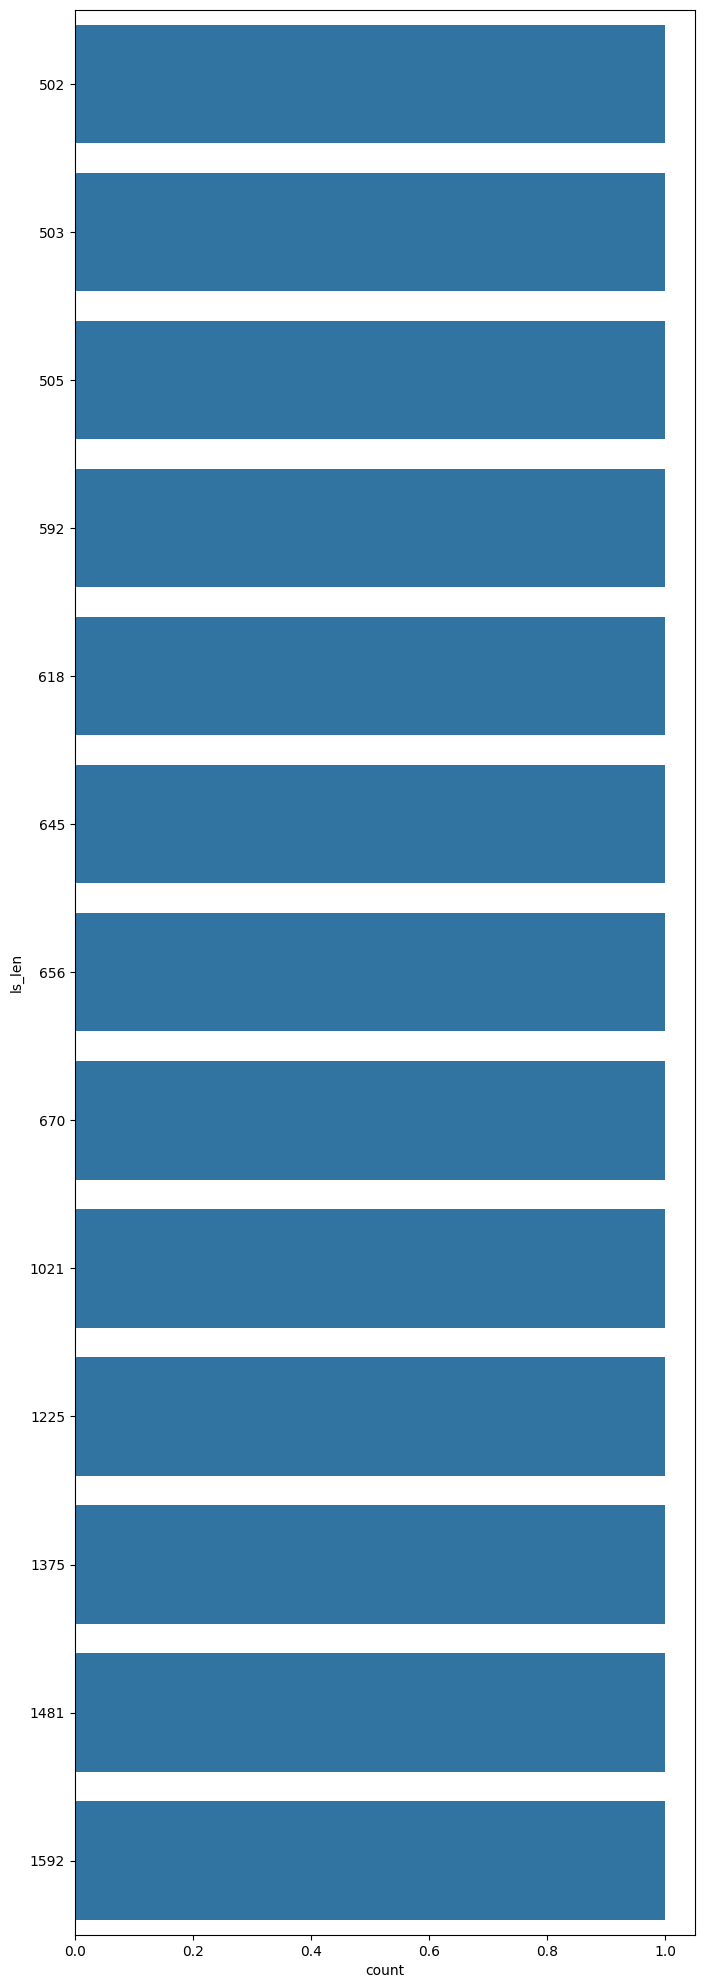

In [205]:
fig, ax = plt.subplots(figsize=(8, 25))
#sns.countplot(y='ls_len', data=df, order=df['ls_len'].value_counts().index)
sns.countplot(y='ls_len', data=df[df['ls_len'] > 500])

In [198]:
def countplot_with_labels(l, title):
  ax = sns.countplot(l, palette='pastel')

  for p in ax.patches:
    ax.text(
      p.get_width() + 1,
      p.get_y() + p.get_height() / 2,
      int(p.get_width()),
      ha="center",
      va="center",
      color="black",
      fontsize=12,
      fontweight="bold"
    )
  
  plt.title(title)

  return plt

In totality, what is the distribution of HCPCS codes across all claims

In [199]:
all_hcpcs = df['combined_hcpcs_ls'].explode().reset_index()
all_hcpcs = all_hcpcs.merge(
  combined_mapper,
  left_on='combined_hcpcs_ls',
  right_on='code',
  how='left'
)
all_hcpcs = all_hcpcs.drop(['index', 'code'], axis=1)
all_hcpcs = all_hcpcs.fillna("Unknown")

In [ ]:
countplot_with_labels(all_hcpcs['category'], "Breakdown of Category for HCPCS")

In [ ]:
countplot_with_labels(all_hcpcs['description'], "Breakdown of Descriptions for HCPCS")

Compare for the first and second HCPCS, what are the most common category of procedures done

In [ ]:
countplot_with_labels(df_plot['description_0'], "Breakdown of First Procedure")

In [ ]:
countplot_with_labels(df_hcpcs_combined['description_3'], "Breakdown of Second Procedure")

## How long between claim submissions

In [ ]:
plt.hist(day_interval.explode('billablePeriod_end_ls'), bins=50)
plt.title("Histogram of all Day Intervals between Claim Submissions")
plt.show()

In [ ]:
plt.hist(df_day_interval['day_interval_0'])
plt.title('How long between the first and second claim submissions in Days')

In [ ]:
%watermark